# CloneTracer for sample A.6

In this notebook we show how to run CloneTracer interactively. This is sometimes helpful to understand the output that the model gives, as it allows to make diagnostic plots along the inference process. 

We use sample A.6 as an example (Figure 1e of the manuscript). This patient harbours the following mutations identified by bulk exome and bulk ATAC (for mitochondrial variants):

* RAD21
* mt:3019G>c
* mt:11652T>C
* mt:10747T>C
* mt:13827A>G

The steps to run CloneTracer using a heuristic tree search approach are the following:

1. Construct all possible trees for the 2 mutations with the highest number of cells covered
2. Run CloneTracer and select the trees with the highest evidence based on the ELBO. 
3. Add the next mutation (by coverage order) to the selected trees in all possible configurations
4. Repeat steps 2 and 3 until all mutations have been added. 
5. Compute the single cell clonal assignments for the selected trees in the final iteration.

## Import packages 

<br>



In [22]:
# Import packages
import os
import sys
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
import itertools
import os
import pickle
import copy

import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta


import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [55]:
patient = "A.6"

# Load data

The first step is to create a python class object which includes all the input data from the json file and has all functions required to run CloneTracer.
The options are the same as in the non-interactive script described in our repository:

* **input_file**: json file with input data
* **name**: sample name
* **mult_samp**: boolean indicating whether bulk data comes from different samples (e.g. different timepoints or cell populations such as T cells and myeloid cells)
* **cnv_celltypes**: boolean indicating whether to use cnv priors. Only required when CNVs are present.
* **gpu**: boolean indicating if CloneTracer should be run on GPU or CPUs.

In [47]:
t = create_tree_class(input_file = "../data/"+patient+".json", 
                      name = patient, 
                      mult_samp = True, 
                      cnv_celltype = False,
                      gpu = True)

Here we select the 2 mutations with the highest coverage

In [48]:
t.sel_mutation(initial = True)

tensor([1, 3])

# Run CloneTracer

## Initial tree with mt:3019G>C & mt:11652T>C

The function select_tree() runs CloneTracer for all trees stored in the "potential_tress" slot of the object and selects those with the lowest ELBO. In this case there are only 4 possible trees as we are only considering 2 mutations. It has the following options:

* **num_iter**: number of total iterations (in our hands 400 for patients with SNVs only and 1000 for CNV samples suffice for ELBO convergence)
* **init**: number of initial iterations to hide in ELBO plot. We recommend to set to at least 100 as the initial iterations can have very high ELBO values
* **num_particles**: number of particles. Default is 5

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 0m 53s
Model fit to tree 1 in 0m 53s
Model fit to tree 2 in 0m 53s
Model fit to tree 3 in 0m 53s
Tree [0] selected for mutations ['X3019.G.C', 'X11652.T.C']:
[tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])]
Total run time 0h 3m 33s


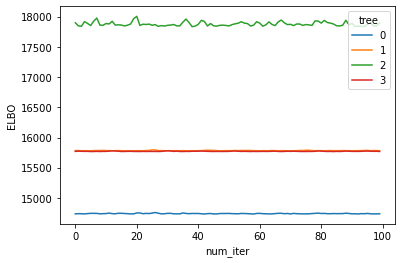

In [50]:
t.select_tree(num_iter = 400, init = 300)

### Print ELBO

We can print the ELBO over the last iterations for a selected number of trees using the print_elbo() function

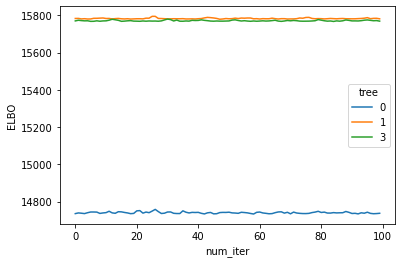

In [51]:
t.print_elbo(num_iter = 400, init = 300, include = [0,1,3])

### Print parameters

It is also useful to analyse how the different parameters of the variational distribution change along the iterations. We can visualize this using the print_params() function.

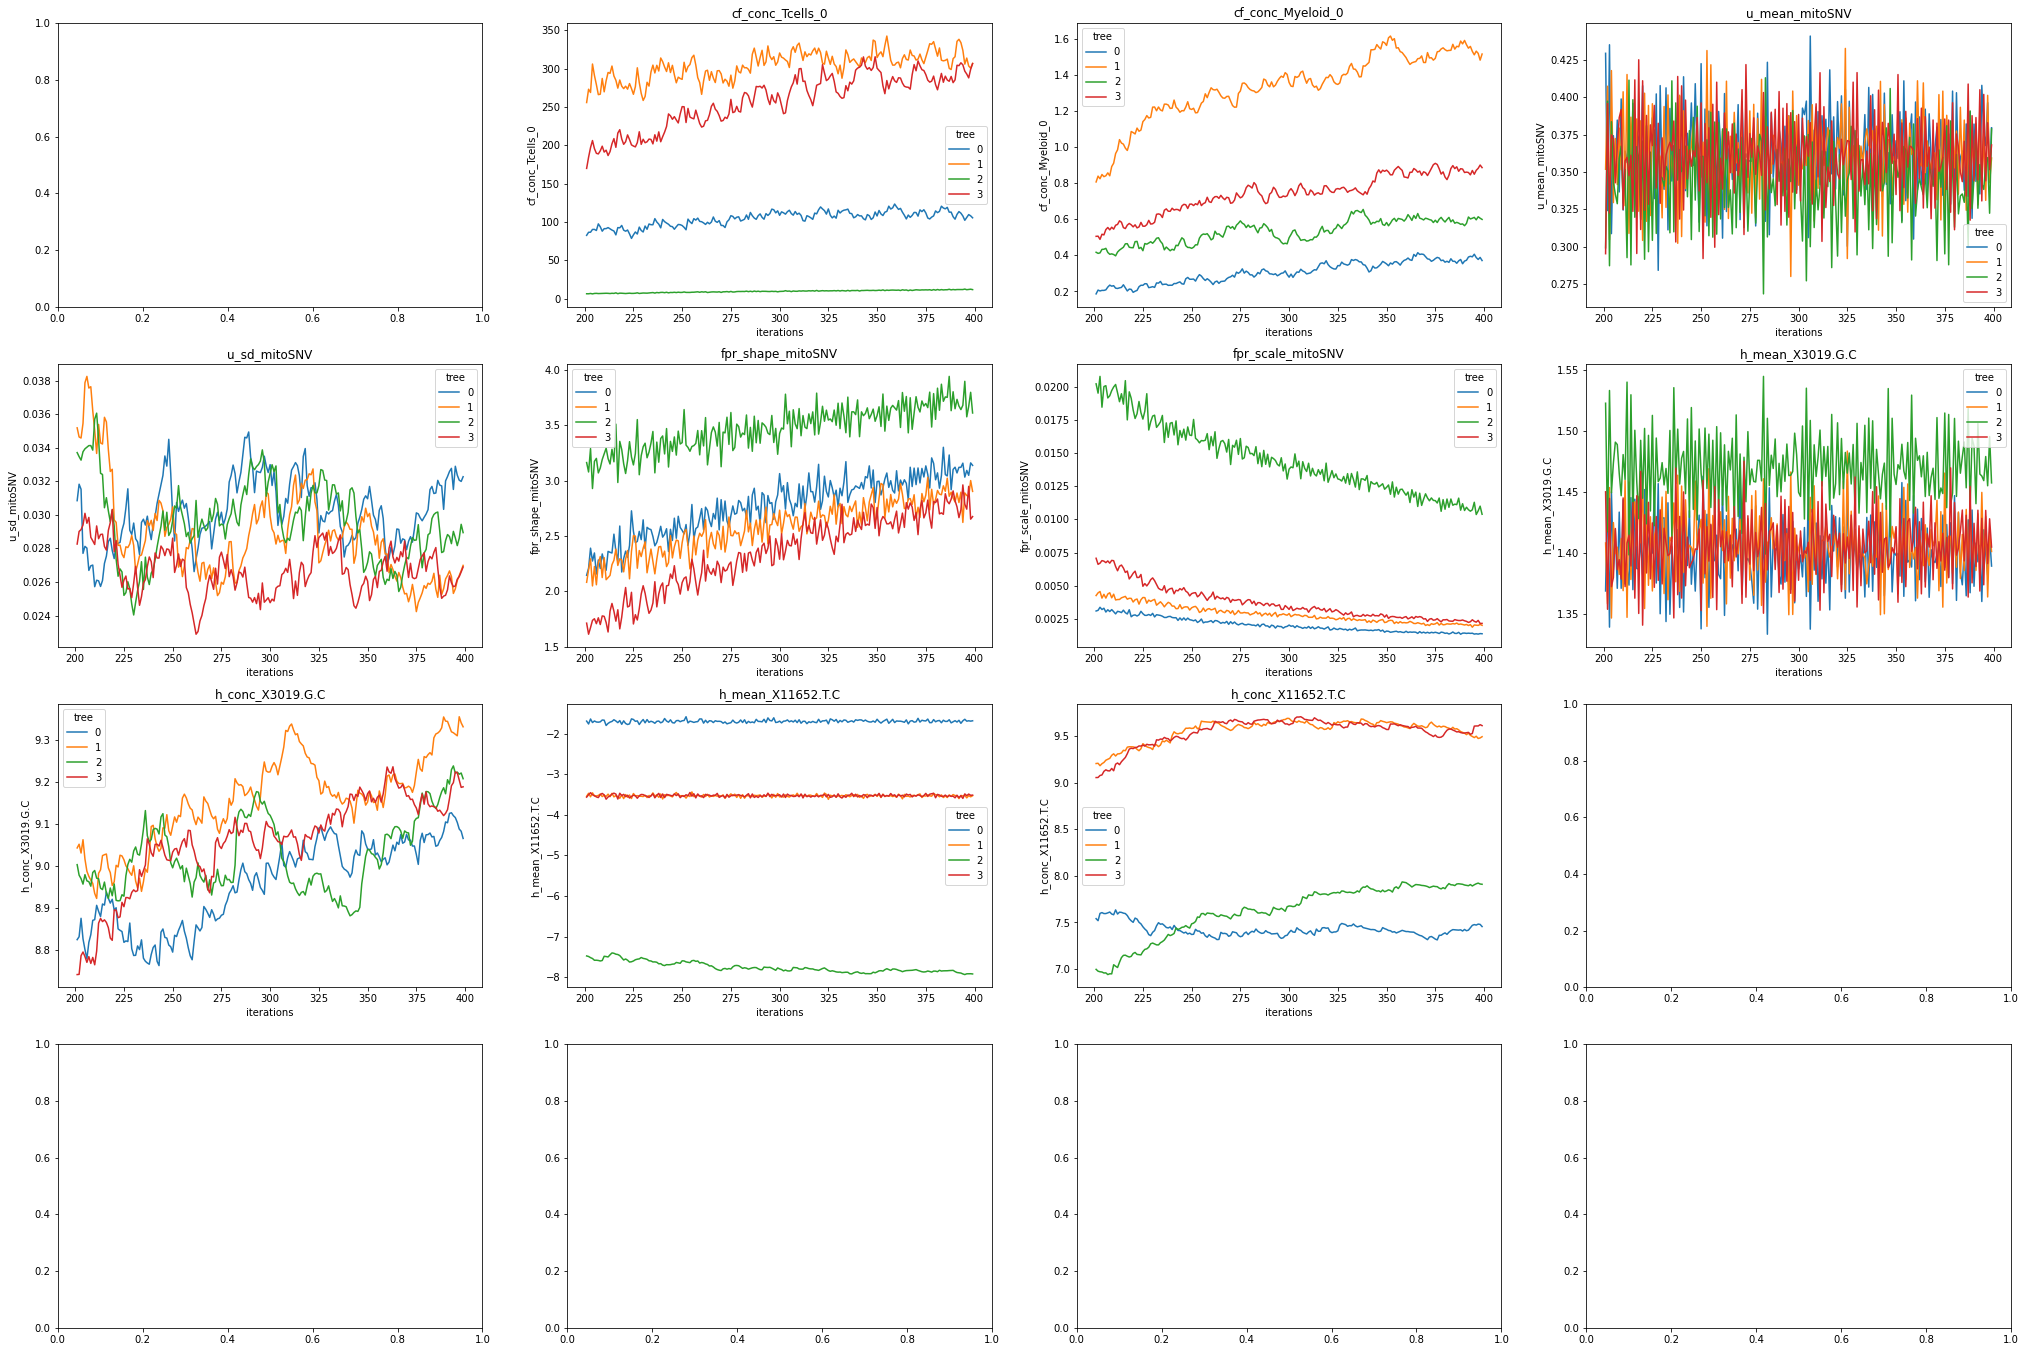

In [52]:
t.print_params(include = [0,1,2,3], it = 200)

### Posterior of latent variables

We can also generate posterior probabilities over the latent variables of the model. This is particularly helpful to understand the output that the model gives sometimes.

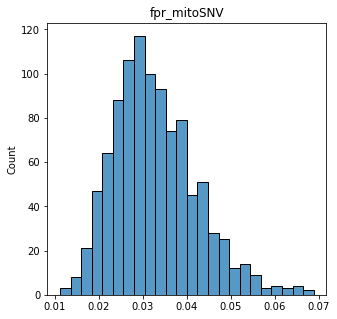

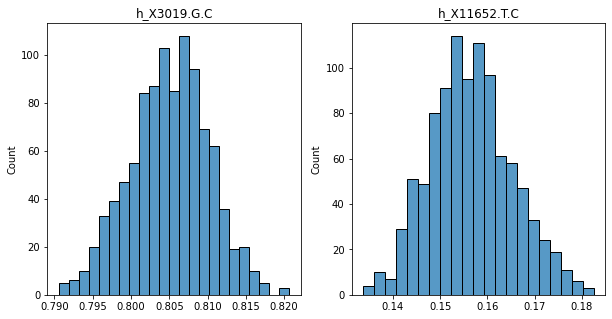

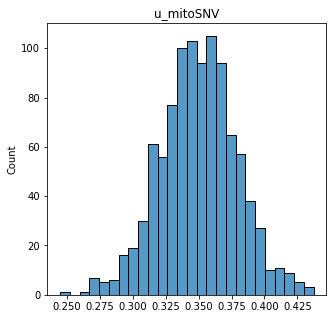

In [53]:
t.plot_posterior(variables = "all", tree = 0, data_points = 1000)

## Add mt:10747T>C

In the next sections we will add the following mutations and run CloneTracer as seen above. We will also generate diagnostic plots

X10747.T.C added to the tree
Choosing best tree among 7 potential candidates
Model fit to tree 0 in 1m 9s
Model fit to tree 1 in 1m 9s
Model fit to tree 2 in 1m 8s
Model fit to tree 3 in 1m 8s
Model fit to tree 4 in 1m 8s
Model fit to tree 5 in 1m 8s
Model fit to tree 6 in 1m 8s
Tree [3] selected for mutations ['X3019.G.C', 'X11652.T.C', 'X10747.T.C']:
[tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.]])]
Total run time 0h 8m 1s


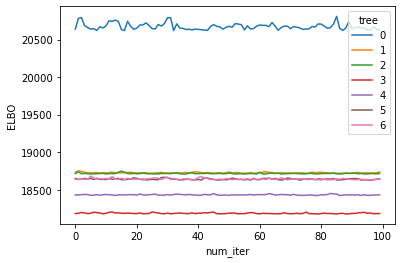

In [54]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 300)

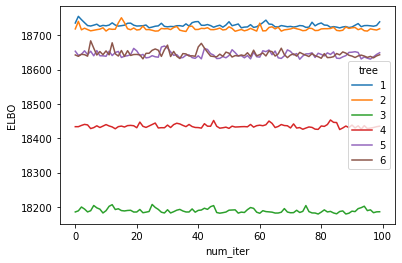

In [56]:
t.print_elbo(num_iter = 400, init = 300, include = [1,2,3,4,5,6])

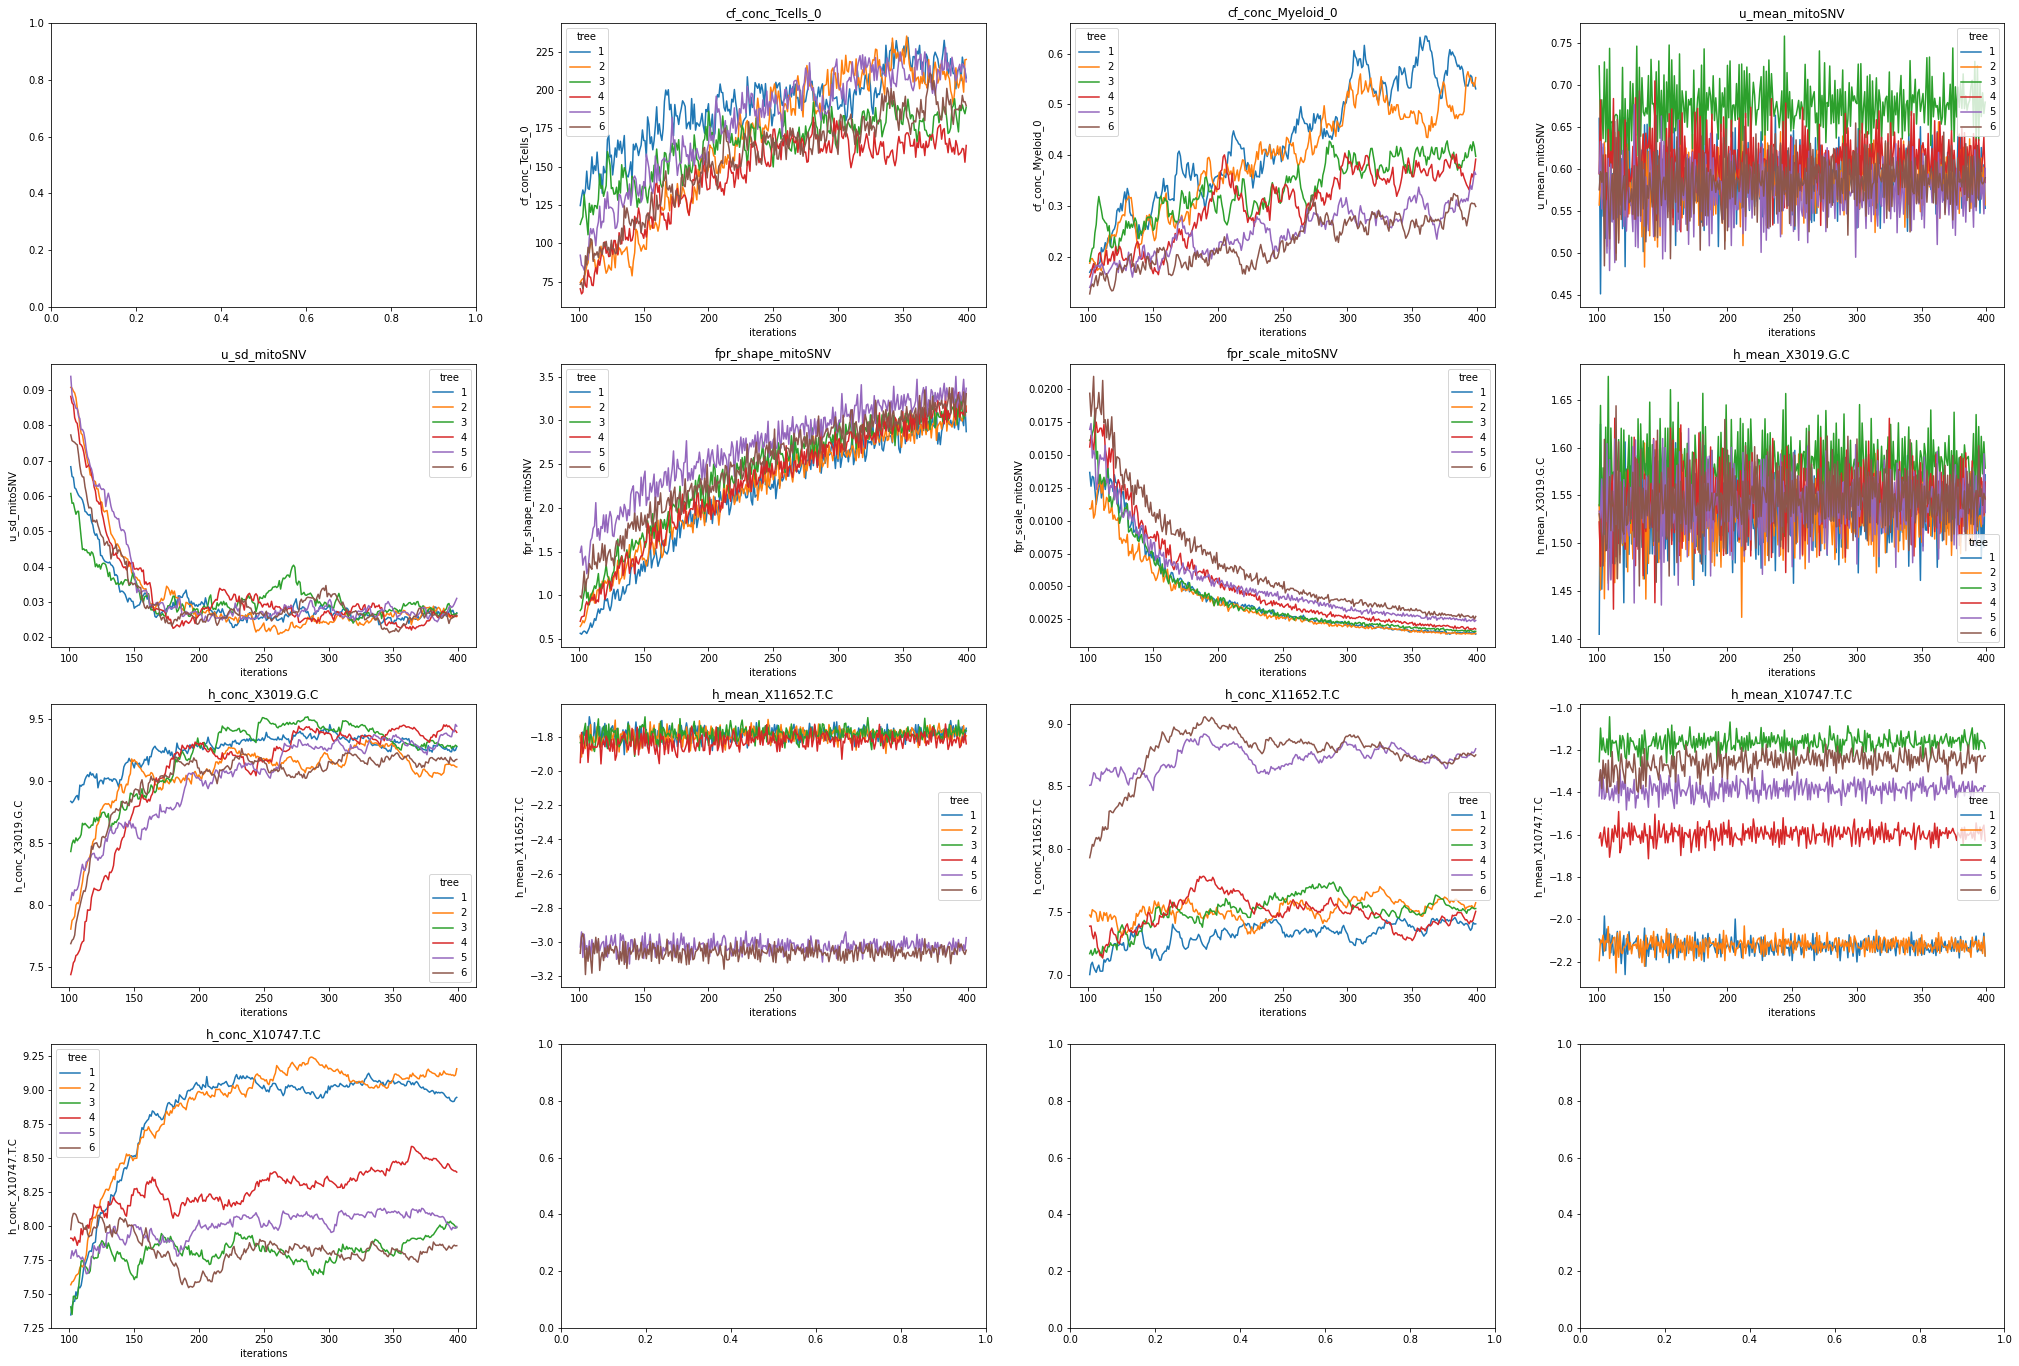

In [57]:
t.print_params(include = [1,2,3,4,5,6], it = 100)

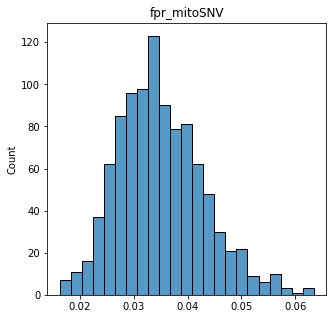

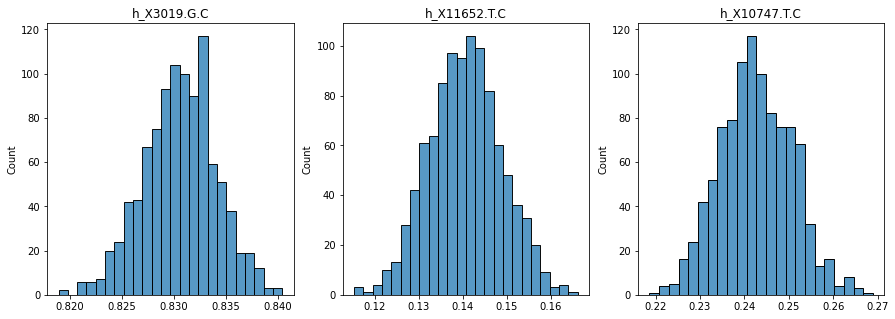

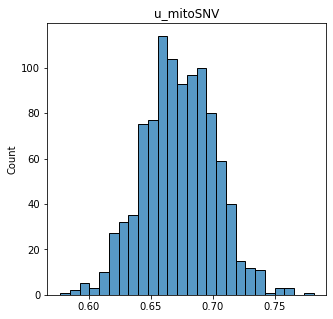

In [58]:
t.plot_posterior("all", 3, 1000)

## Add mt:13827A>G

X13827.A.G added to the tree
Choosing best tree among 11 potential candidates
Model fit to tree 0 in 1m 24s
Model fit to tree 1 in 1m 24s
Model fit to tree 2 in 1m 24s
Model fit to tree 3 in 1m 24s
Model fit to tree 4 in 1m 25s
Model fit to tree 5 in 1m 24s
Model fit to tree 6 in 1m 25s
Model fit to tree 7 in 1m 25s
Model fit to tree 8 in 1m 24s
Model fit to tree 9 in 1m 24s
Model fit to tree 10 in 1m 24s
Tree [10] selected for mutations ['X3019.G.C', 'X11652.T.C', 'X10747.T.C', 'X13827.A.G']:
[tensor([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.]])]
Total run time 0h 15m 30s


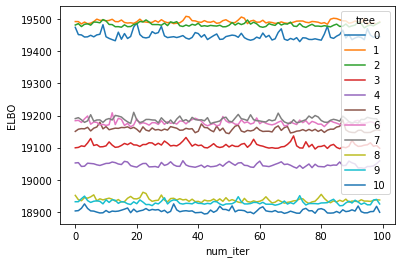

In [59]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 300)

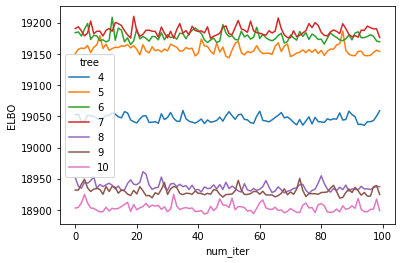

In [60]:
t.print_elbo(num_iter = 400, init = 300, include = [4,5,6,7,8,9,10])

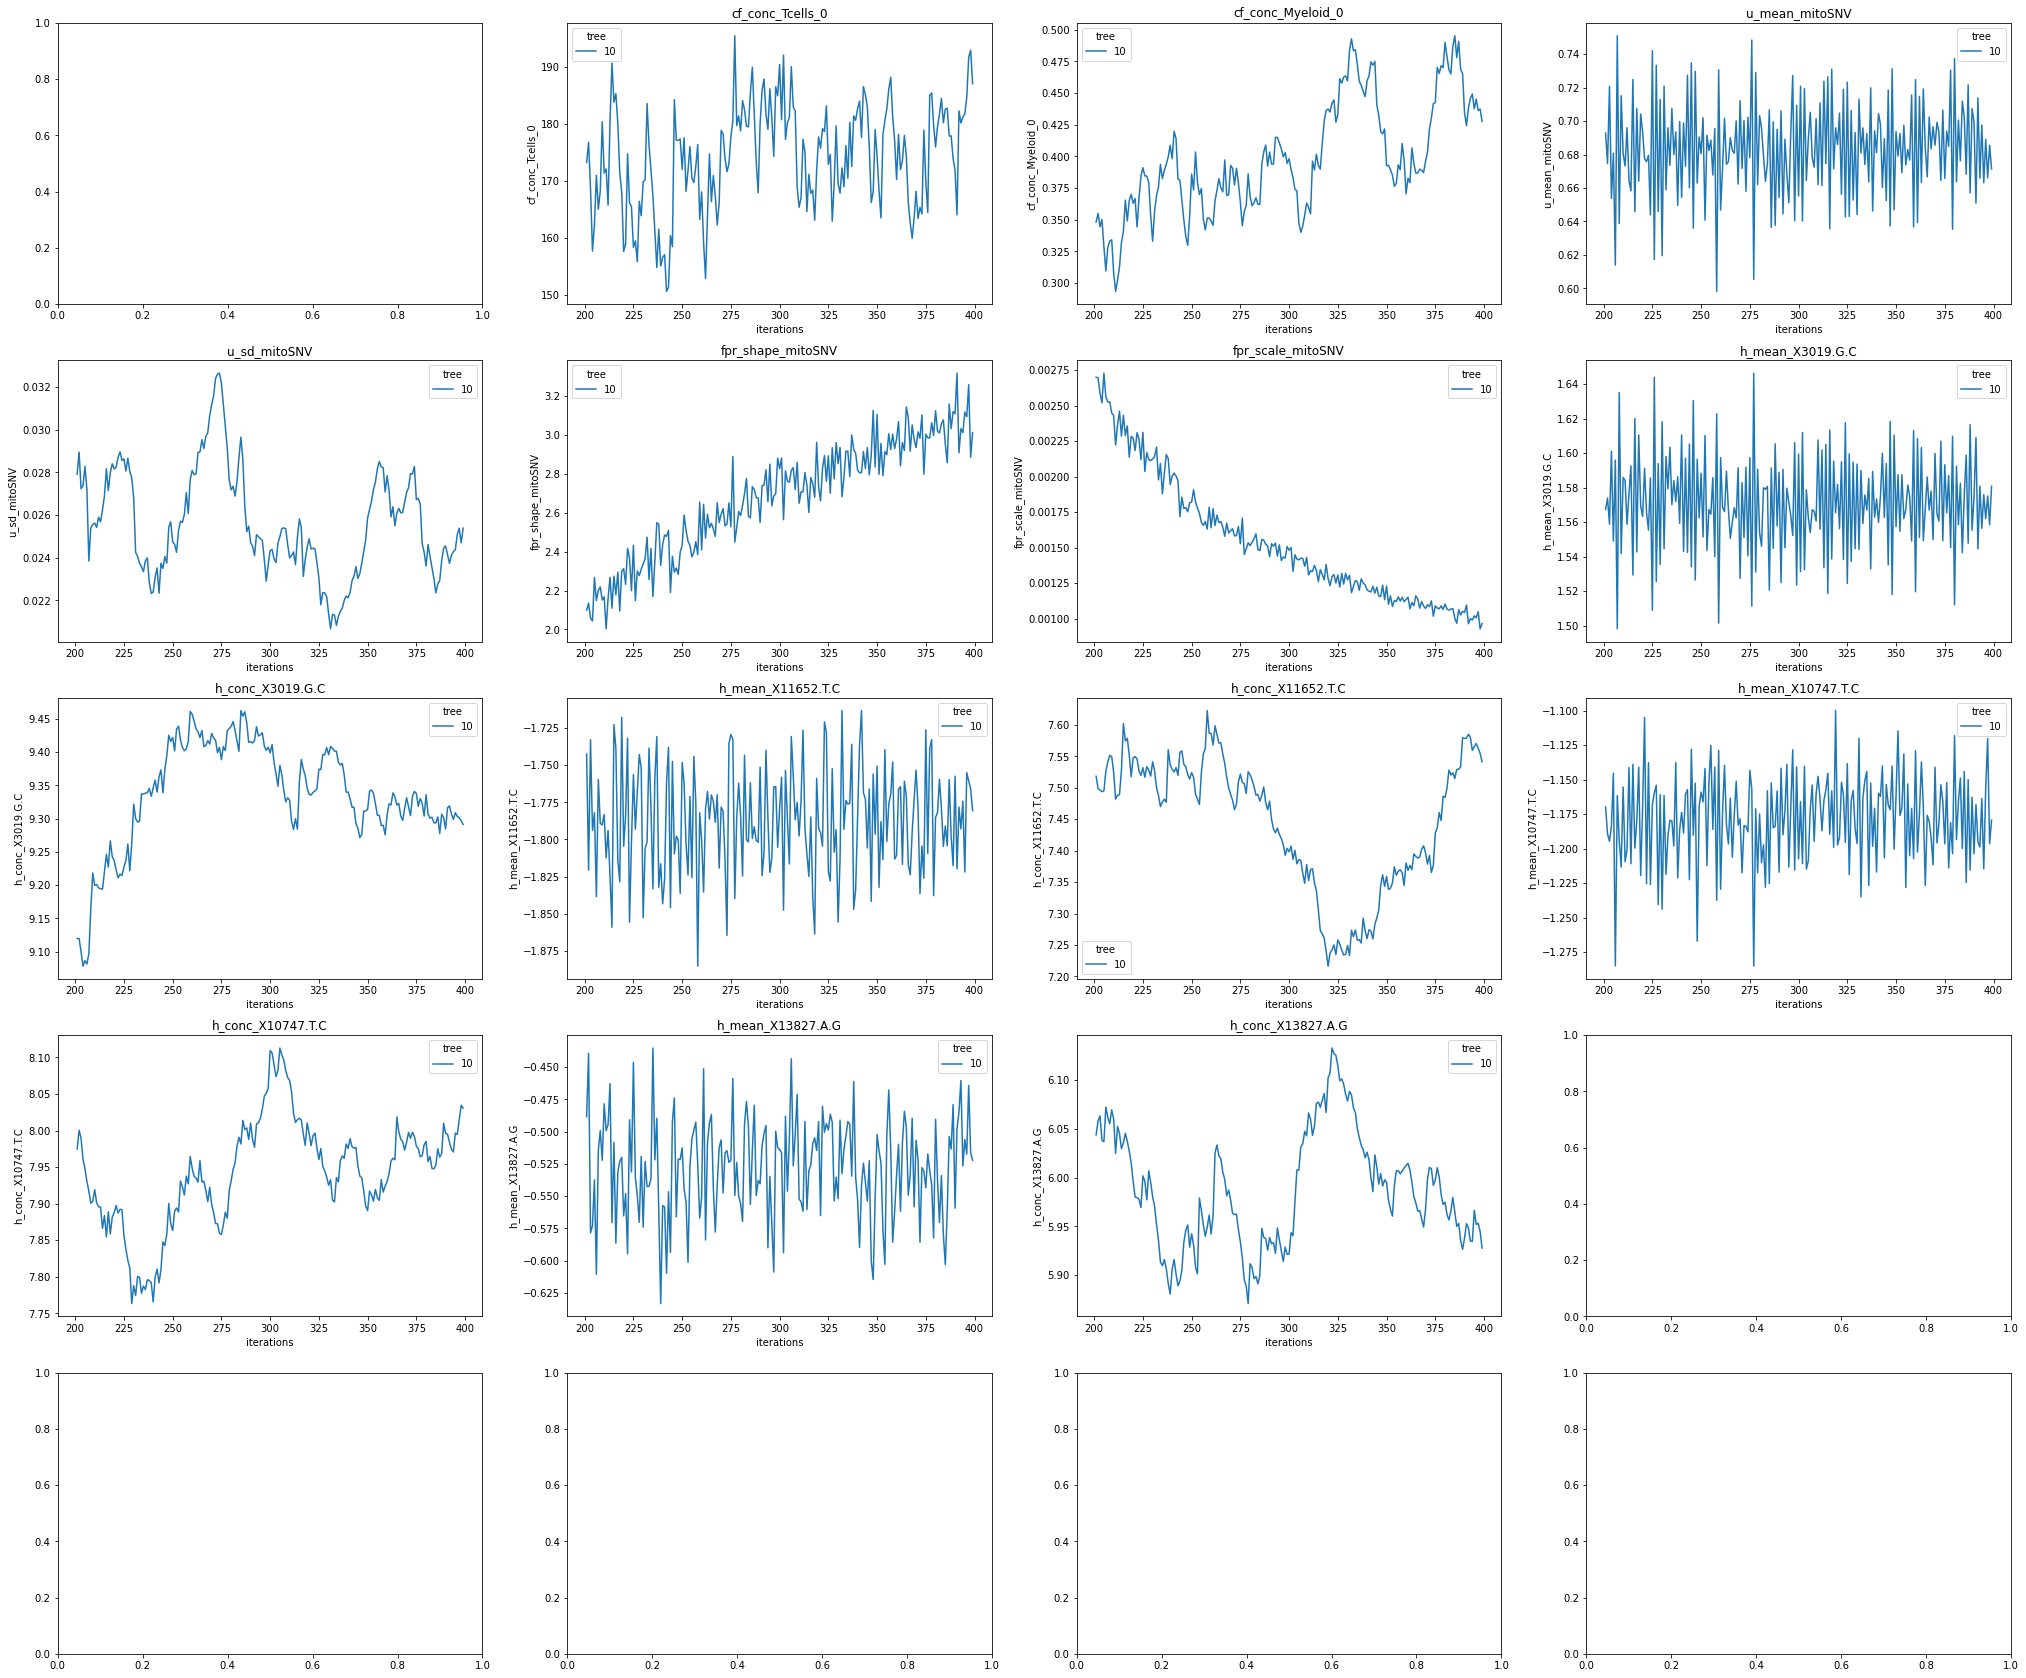

In [61]:
t.print_params(include = t.tree_indices, it = 200)

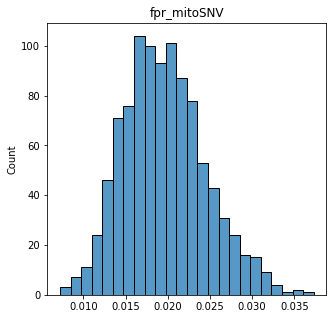

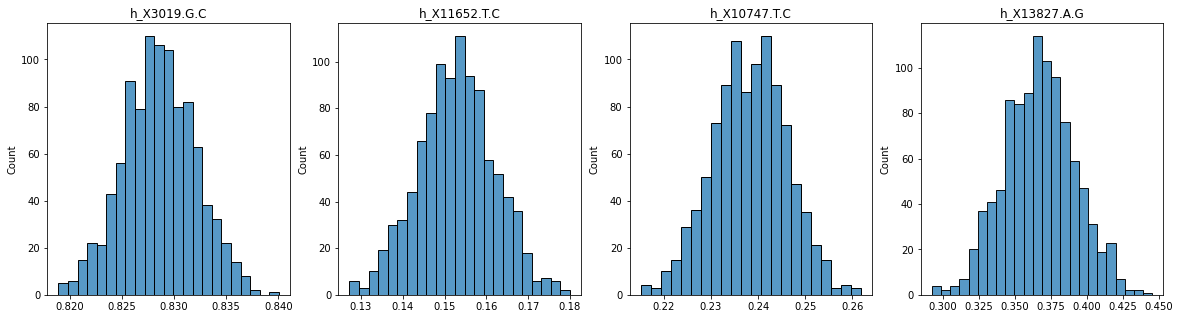

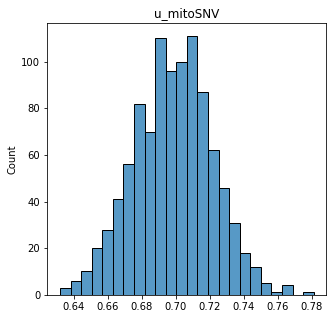

In [62]:
t.plot_posterior("all", 10, 1000)

## Add mt:2960T>C

X2960.T.C added to the tree
Choosing best tree among 14 potential candidates
Model fit to tree 0 in 1m 45s
Model fit to tree 1 in 1m 53s
Model fit to tree 2 in 1m 49s
Model fit to tree 3 in 1m 38s
Model fit to tree 4 in 1m 44s
Model fit to tree 5 in 1m 25s
Model fit to tree 6 in 1m 46s
Model fit to tree 7 in 1m 47s
Model fit to tree 8 in 1m 47s
Model fit to tree 9 in 1m 45s
Model fit to tree 10 in 1m 46s
Model fit to tree 11 in 1m 46s
Model fit to tree 12 in 1m 46s
Model fit to tree 13 in 1m 43s
Trees [8, 2, 5, 6] selected for mutations ['X9837.G.A', 'X6999.G.A', 'X6933.T.C', 'NPM1', 'X2960.T.C']
tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0.],
        [1., 1., 0., 1., 1.]])
tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1.]])
tensor([[0., 0., 0., 0., 0.],
    

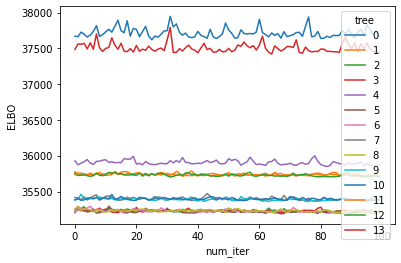

In [16]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 300, init = 200)
with open("output/tree_"+patient+".pickle", "wb") as f:
    pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)

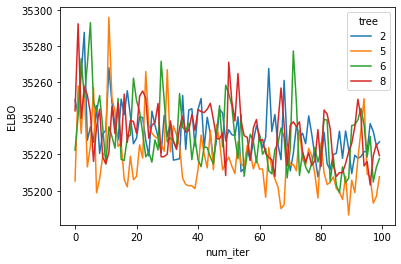

In [18]:
t.print_elbo(num_iter = 300, init = 200, include = t.tree_indices)

## Add RAD21

In [ ]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 300)

RAD21 added to the tree
Choosing best tree among 14 potential candidates
Model fit to tree 0 in 1m 52s
Model fit to tree 1 in 1m 53s


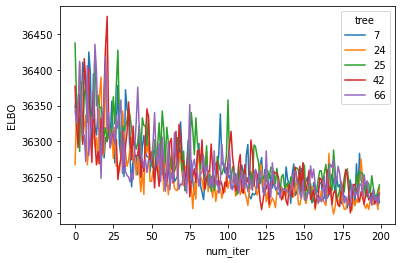

In [21]:
t.print_elbo(num_iter = 300, init = 100, include = t.tree_indices)

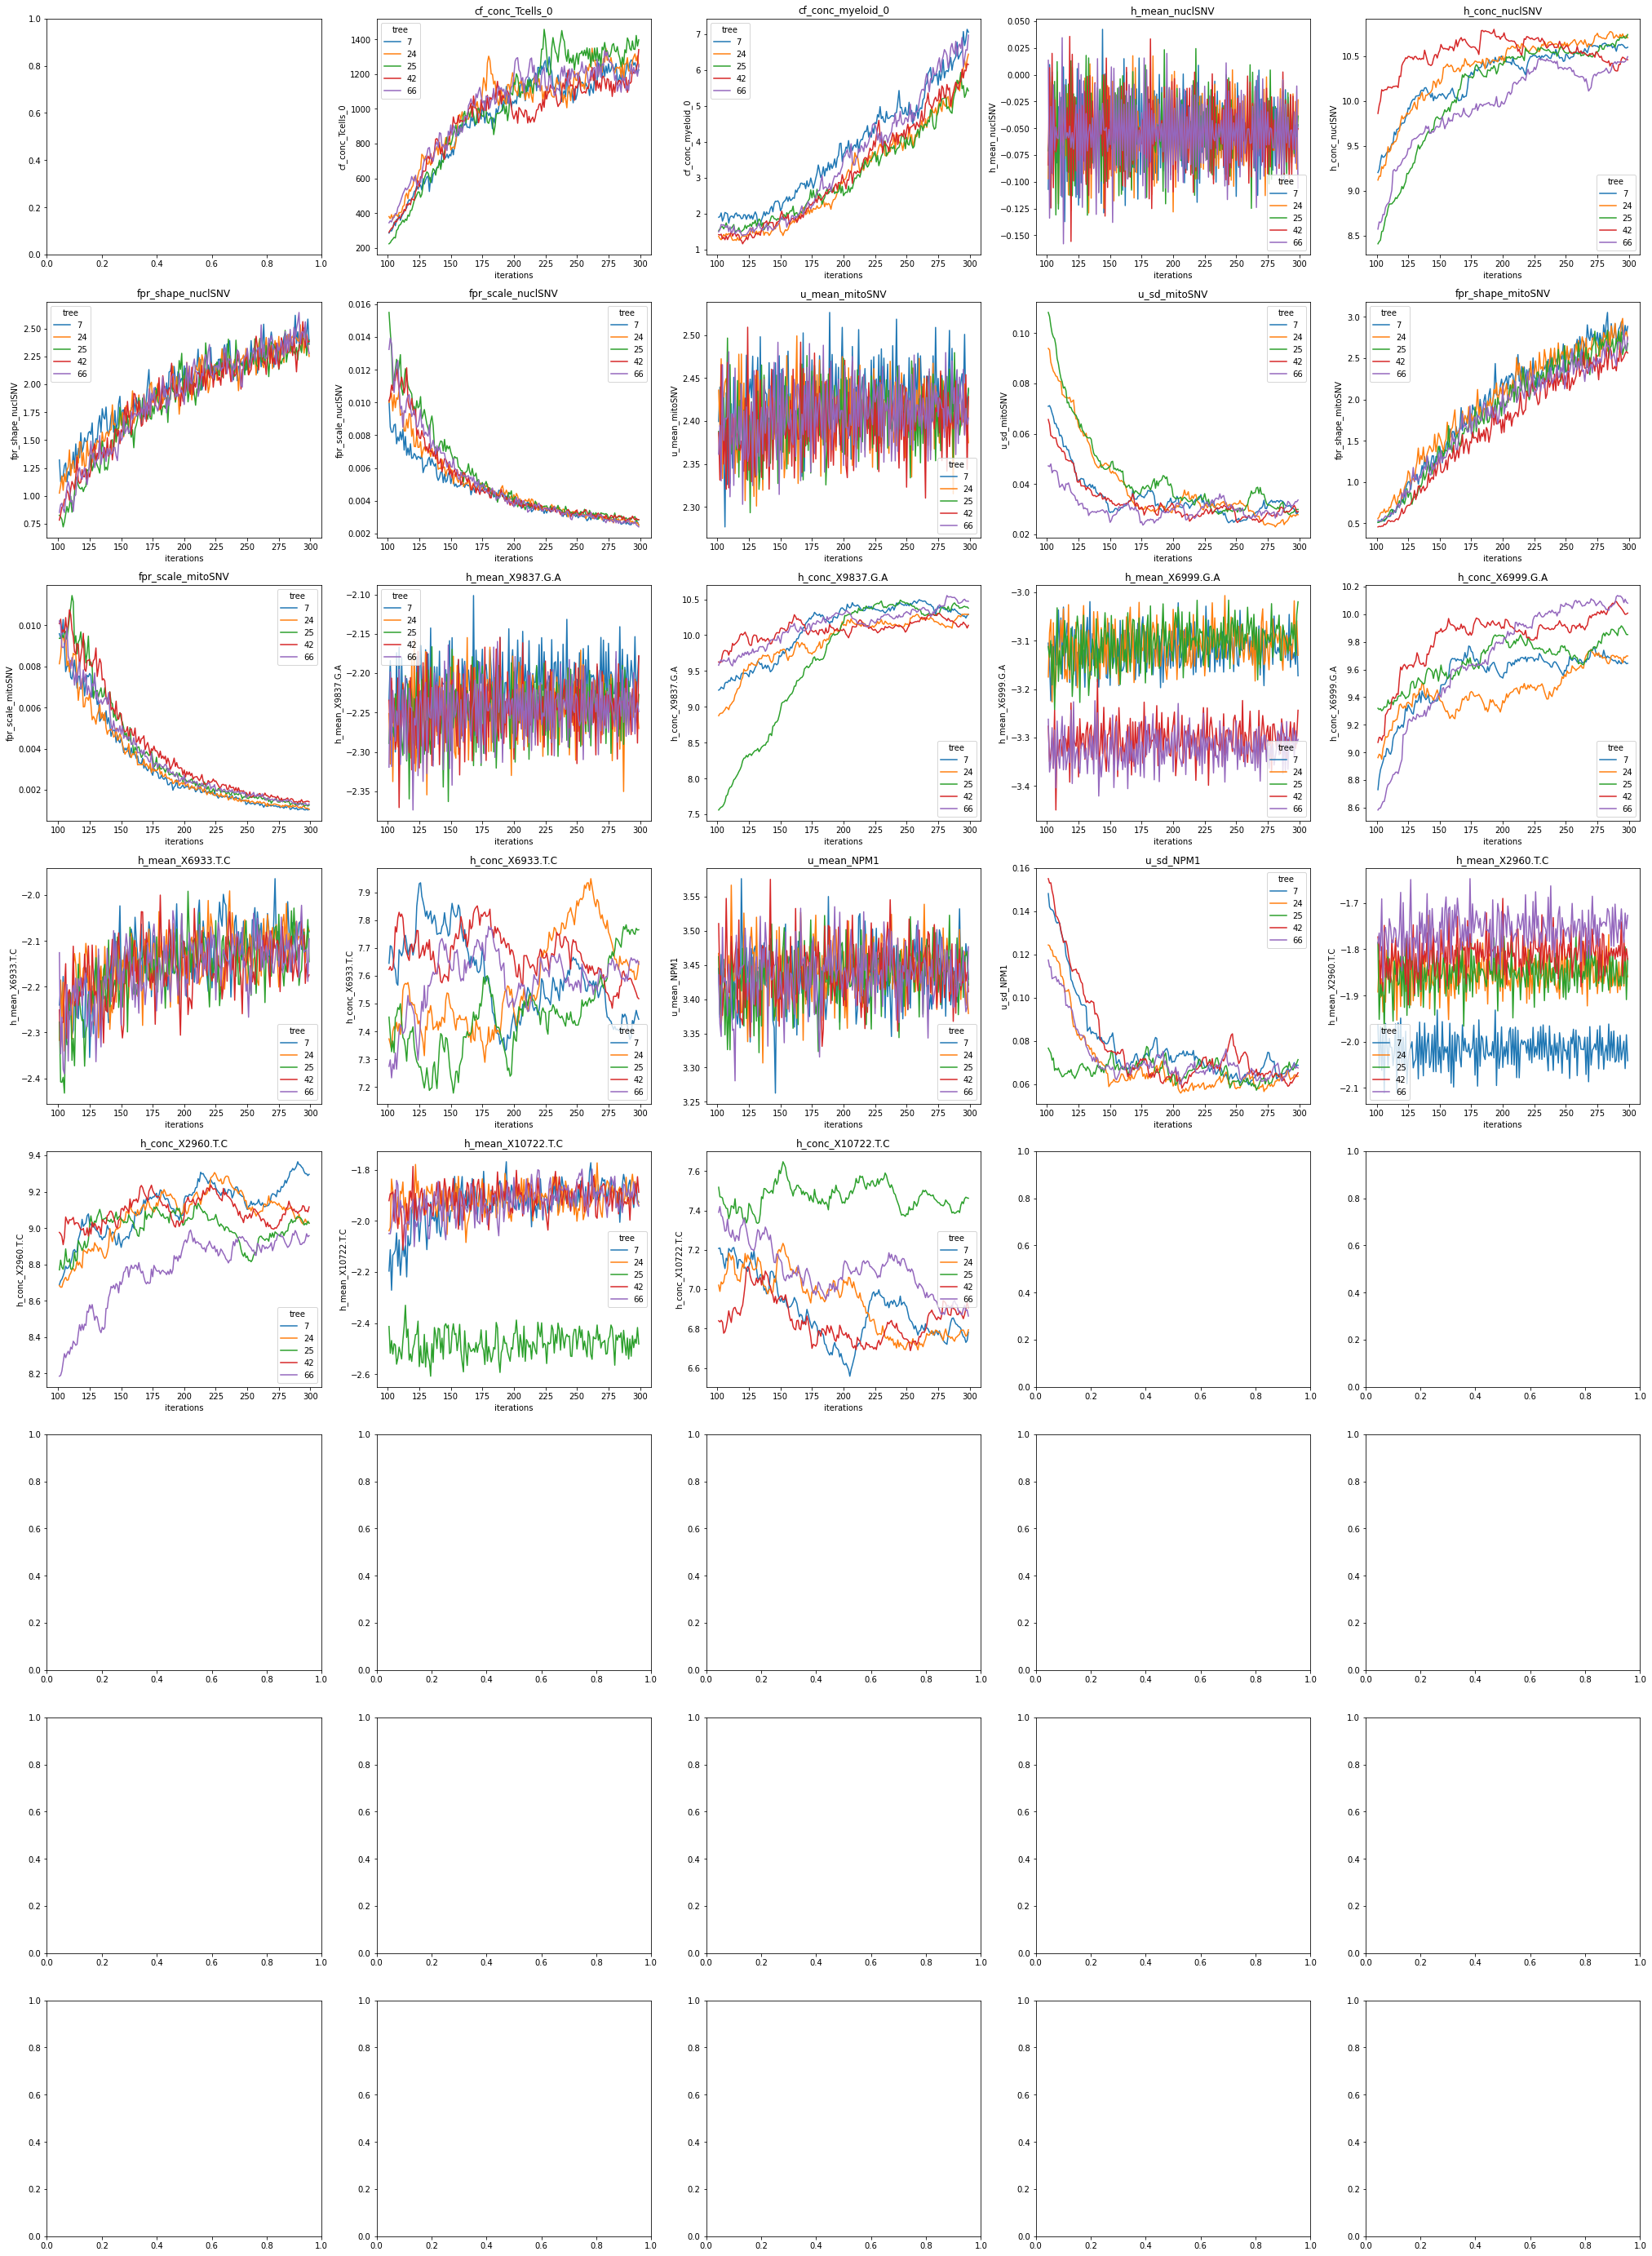

In [22]:
t.print_params(include = t.tree_indices, it = 100)

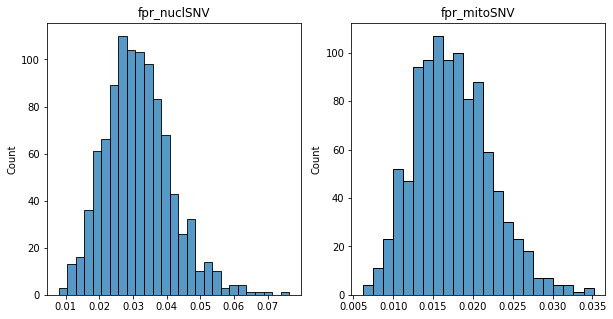

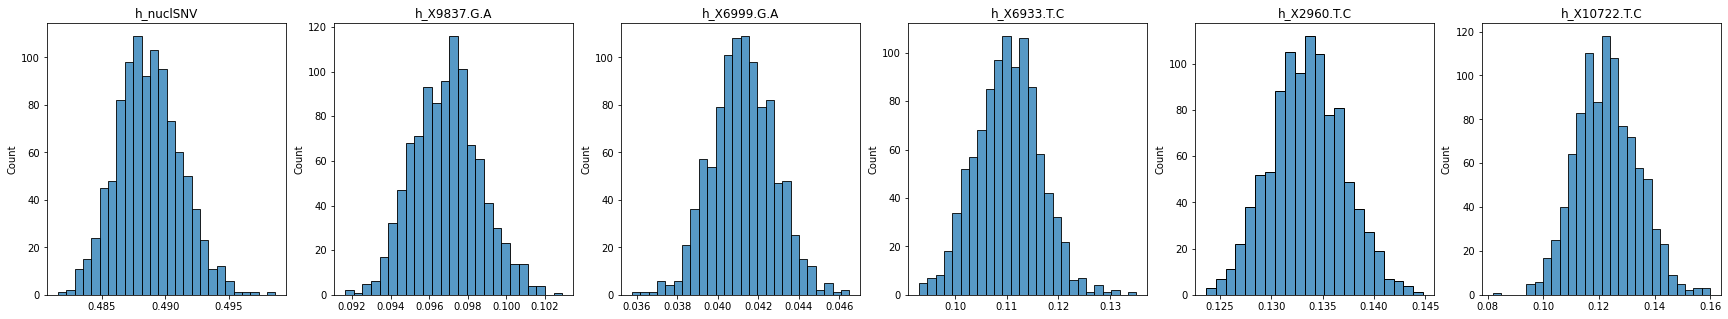

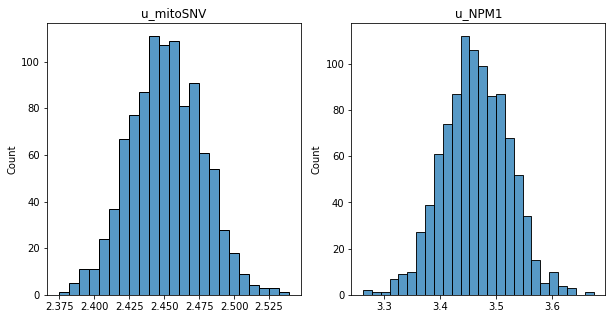

In [23]:
t.plot_posterior("all", 24, 1000)

Choosing best tree among 105 potential candidates
Model fit to tree 0 in 2m 12s
Model fit to tree 1 in 2m 16s
Model fit to tree 2 in 2m 16s
Model fit to tree 3 in 2m 15s
Model fit to tree 4 in 2m 15s
Model fit to tree 5 in 2m 15s
Model fit to tree 6 in 2m 15s
Model fit to tree 7 in 2m 16s
Model fit to tree 8 in 2m 17s
Model fit to tree 9 in 2m 19s
Model fit to tree 10 in 2m 19s
Model fit to tree 11 in 2m 15s
Model fit to tree 12 in 2m 15s
Model fit to tree 13 in 2m 17s
Model fit to tree 14 in 2m 16s
Model fit to tree 15 in 2m 14s
Model fit to tree 16 in 2m 15s
Model fit to tree 17 in 2m 14s
Model fit to tree 18 in 2m 14s
Model fit to tree 19 in 2m 13s
Model fit to tree 20 in 2m 14s
Model fit to tree 21 in 2m 14s
Model fit to tree 22 in 2m 12s
Model fit to tree 23 in 2m 15s
Model fit to tree 24 in 2m 13s
Model fit to tree 25 in 2m 12s
Model fit to tree 26 in 2m 5s
Model fit to tree 27 in 2m 12s
Model fit to tree 28 in 2m 14s
Model fit to tree 29 in 2m 14s
Model fit to tree 30 in 2m 13s


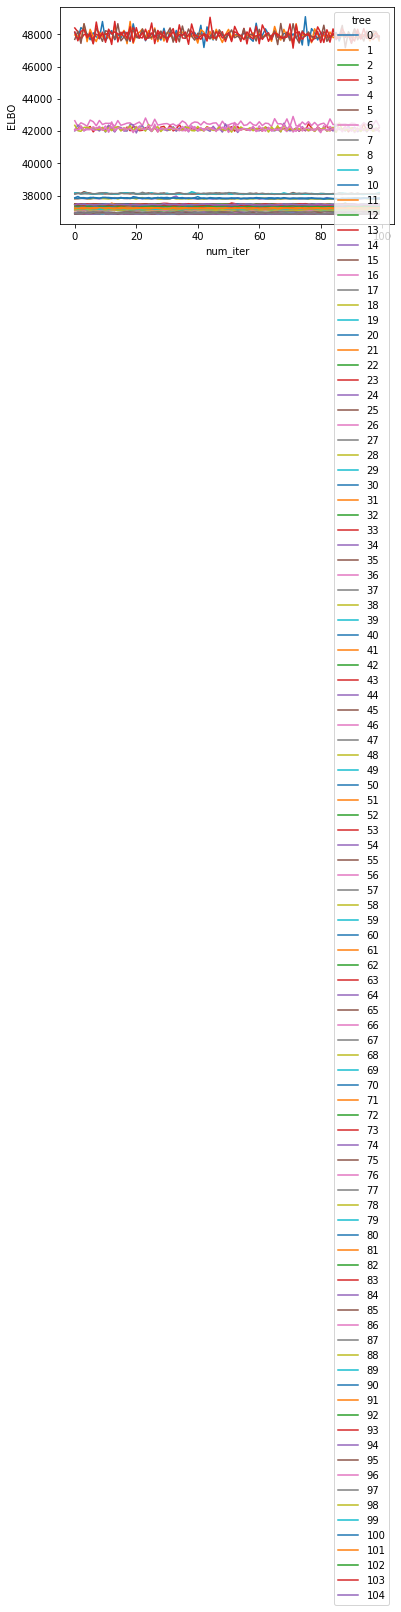

In [26]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 300, init = 200)
with open("output/tree_"+patient+".pickle", "wb") as f:
    pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)

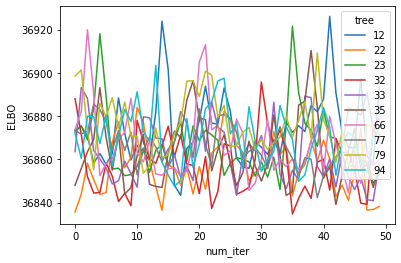

In [28]:
t.print_elbo(num_iter = 300, init = 250, include = t.tree_indices)

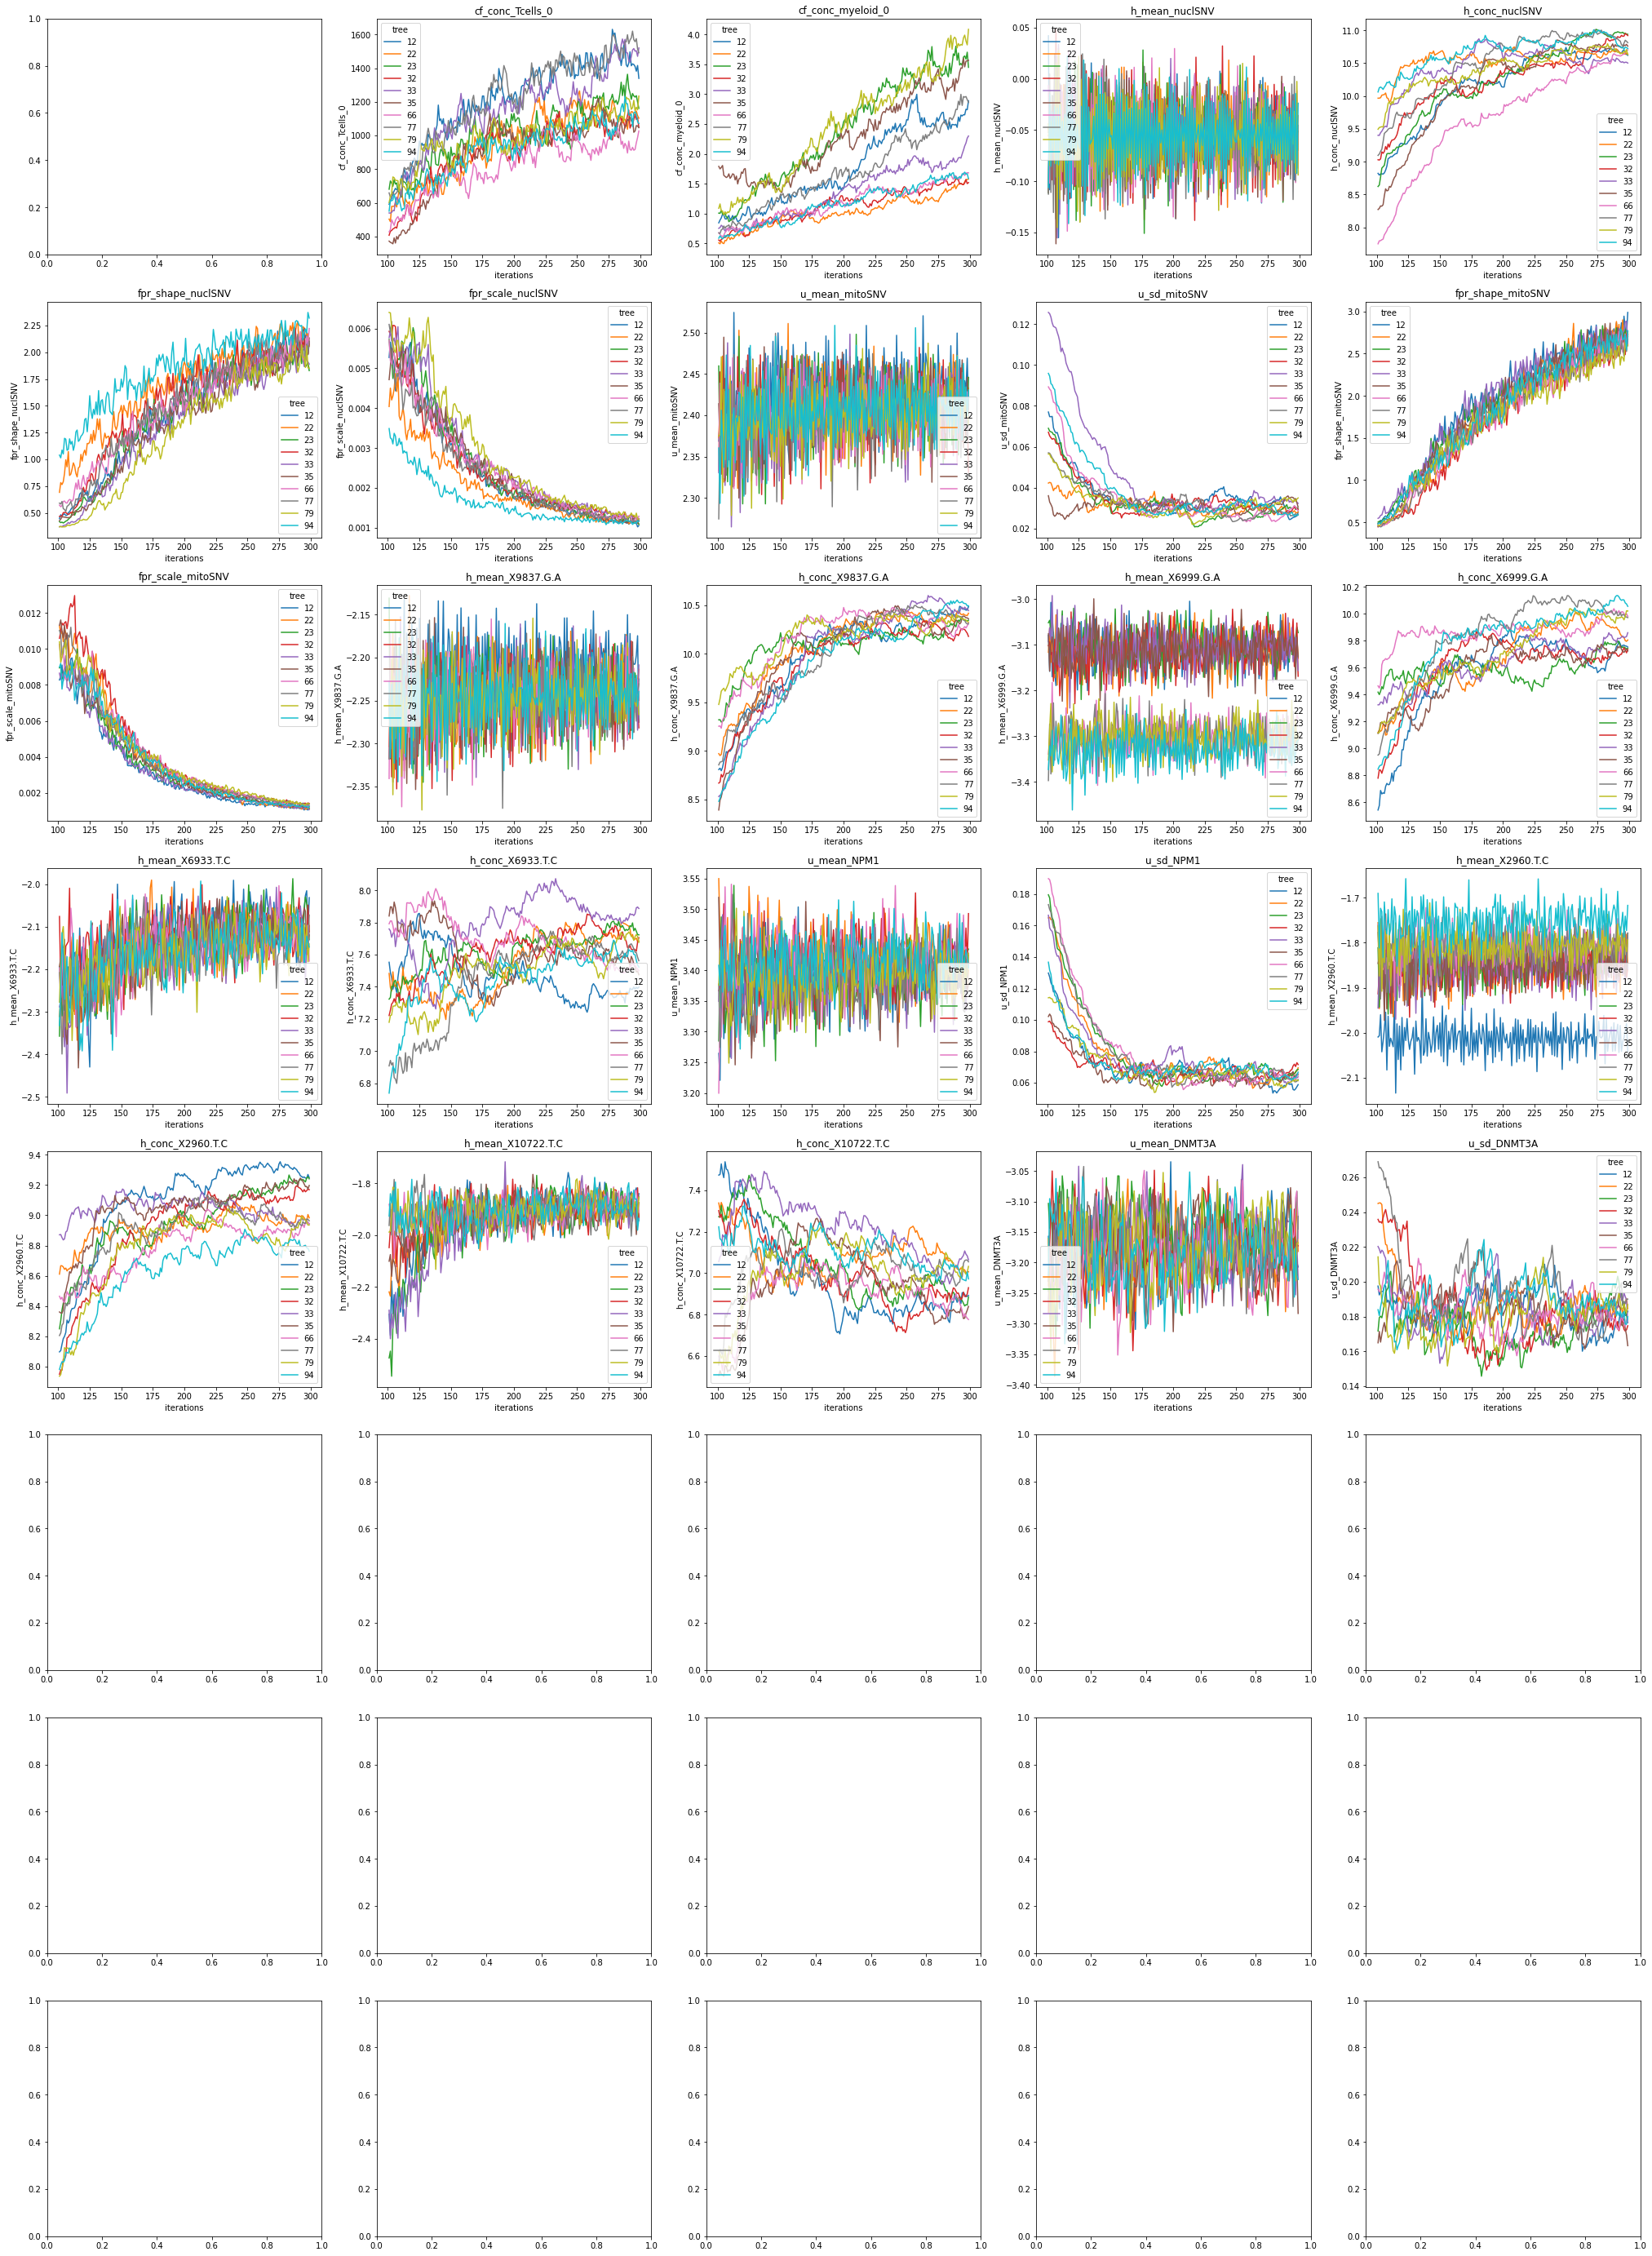

In [29]:
t.print_params(include = t.tree_indices, it = 100)

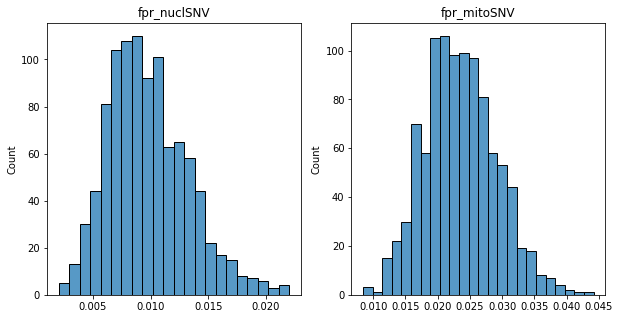

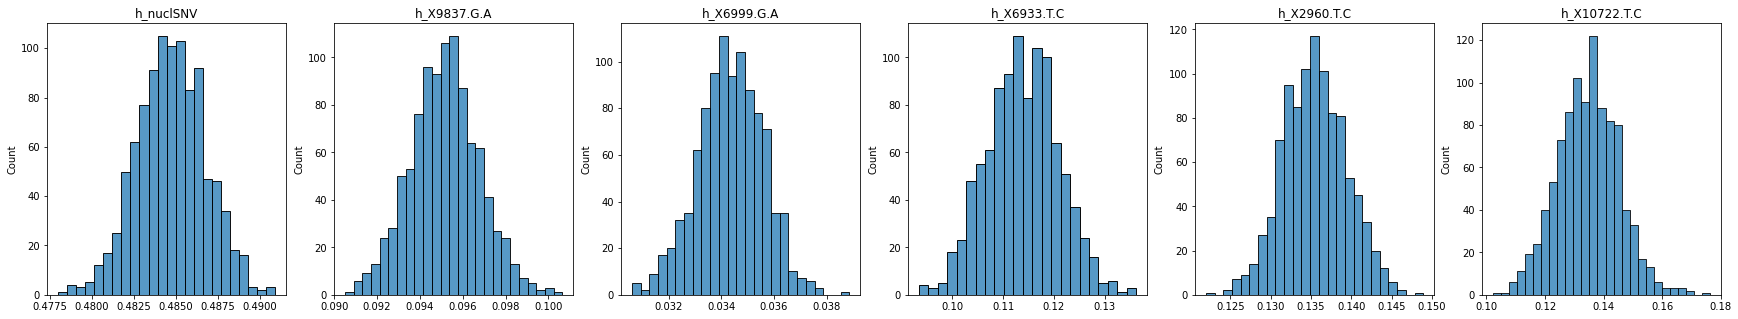

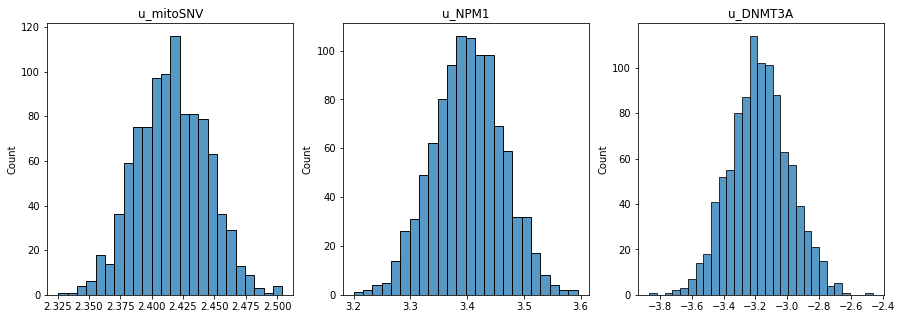

In [34]:
t.plot_posterior("all", 77, 1000)

# Compute clonal assignments

Once all mutations have been added we compute the clonal assignments for each single cell in all selected tree configurations. CloneTracer infers the posterior probability of each cell to belong to the clones of the selected trees. These probabilities are used in downstream analysis to assign cells as healthy or cancer clones

In [30]:
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 2m and 23s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 2m and 23s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 2m and 23s
Computing clonal assignment probabilities for tree 3
Clonal assignment probabilities computed in 2m and 24s
Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 2m and 25s
Computing clonal assignment probabilities for tree 5
Clonal assignment probabilities computed in 2m and 21s
Computing clonal assignment probabilities for tree 6
Clonal assignment probabilities computed in 2m and 22s
Computing clonal assignment probabilities for tree 7
Clonal assignment probabilities computed in 2m and 14s
Computing clonal assignment probabilities for tree 8
Clonal assignment probabilities computed in 2m and 25s
Computing clonal assignment 

# Export output

We export the results from the model as a pickle object. Downstream analysis is done in R. We provide costum functions to generate informative plots as well as an example report in the [vignette](https://github.com/veltenlab/CloneTracer/tree/master/clonal_inference/vignettes) section of our repository. 

In [31]:
# export object as pickle
t.export_pickle("output/"+patient+".pickle")

Tree object saved as pickle!


We can also save the class object as pickle in case we want to generate diagnostic plots in the future or compute posterior predictive checks

In [32]:
with open("output/tree_"+patient+".pickle", "wb") as f:
    pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)